In [1]:
import os
import mido
import utils ##
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\Jafet Velásquez Luna\\Documents\\Cursos\\Dip - IA Aplicada\\Proyecto Final\\hum_transcription_Project_DIA\\utils\\__init__.py'>

# Importar MIDI info

In [3]:
df_midis_info = pd.read_csv('datos_procesados/midis/midis_info.csv', index_col=0)
df_midis_notas = pd.read_csv('datos_procesados/midis/midis_notas.csv', index_col=0)

In [4]:
# Tipos de MIDI
df_non_standard = pd.read_csv('datos_procesados/midis/tipos/no_estandar.csv', index_col=0)
df_standard = pd.read_csv('datos_procesados/midis/tipos/estandar.csv', index_col=0)

In [5]:
df_midi = df_standard.merge(df_midis_info, how='left', left_index=True, right_index=True)
df_midi = df_midi.drop(columns=['problem?'])
df_midi = df_midi.rename({'velocity':'velocity_start'}, axis=1)

In [6]:
lowest_time = df_midi.min_time.min()
print(lowest_time, 's')

0.125 s


# Extraer datos

## Onsets
Onset hace referencia al inicio de un sonido o una nota musical. Se pueden detectar con el incremento de la amplitud de las ondas o con métodos más sofisticados. En este caso, ya que el objetivo emparejar la `ejecución de las notas de tarareos` con su ejecución en MIDI, se buscará el primer **onset** y se emparejará con el inicio del primer `note_on` con $\text{velocity} = 0$ del MIDI.

In [7]:
# Función para extraer los onsets del archivo de audio
def extract_audio_onsets(audio_path, sr=22050):
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Detección de onsets
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=False, units='time')
    
    return onset_frames

In [8]:
audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'

# Extraer onsets del audio
audio_onsets = extract_audio_onsets(audio_path)


[Text(0.5, 0, 'time'), Text(0, 0.5, 'E')]

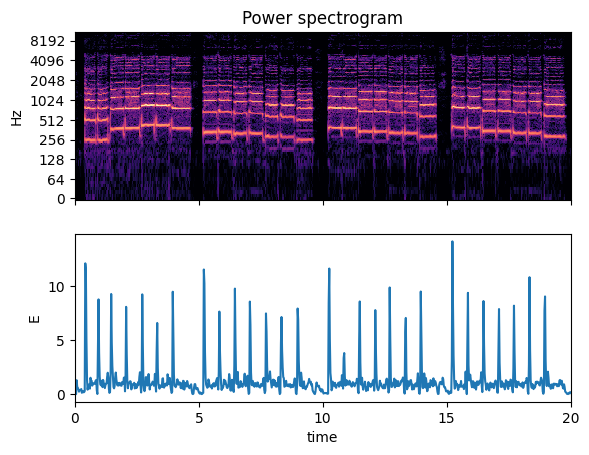

In [28]:
import matplotlib.pyplot as plt

audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
y, sr = librosa.load(audio_path)

o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].set(xlabel='time', ylabel='E')


[Text(0.5, 0, 'time'), Text(0, 0.5, 'E')]

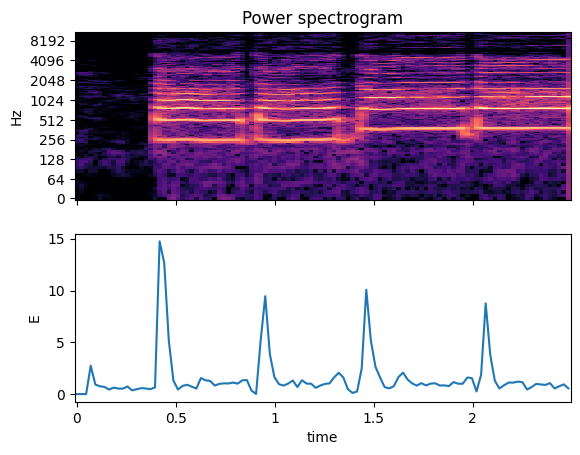

In [41]:
import matplotlib.pyplot as plt

audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
y, sr = librosa.load(audio_path)

o_env = librosa.onset.onset_strength(y=y[:len(y)//8], sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

D = np.abs(librosa.stft(y[:len(y)//8]))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].set(xlabel='time', ylabel='E')


[Text(0.5, 0, 'time'), Text(0, 0.5, '')]

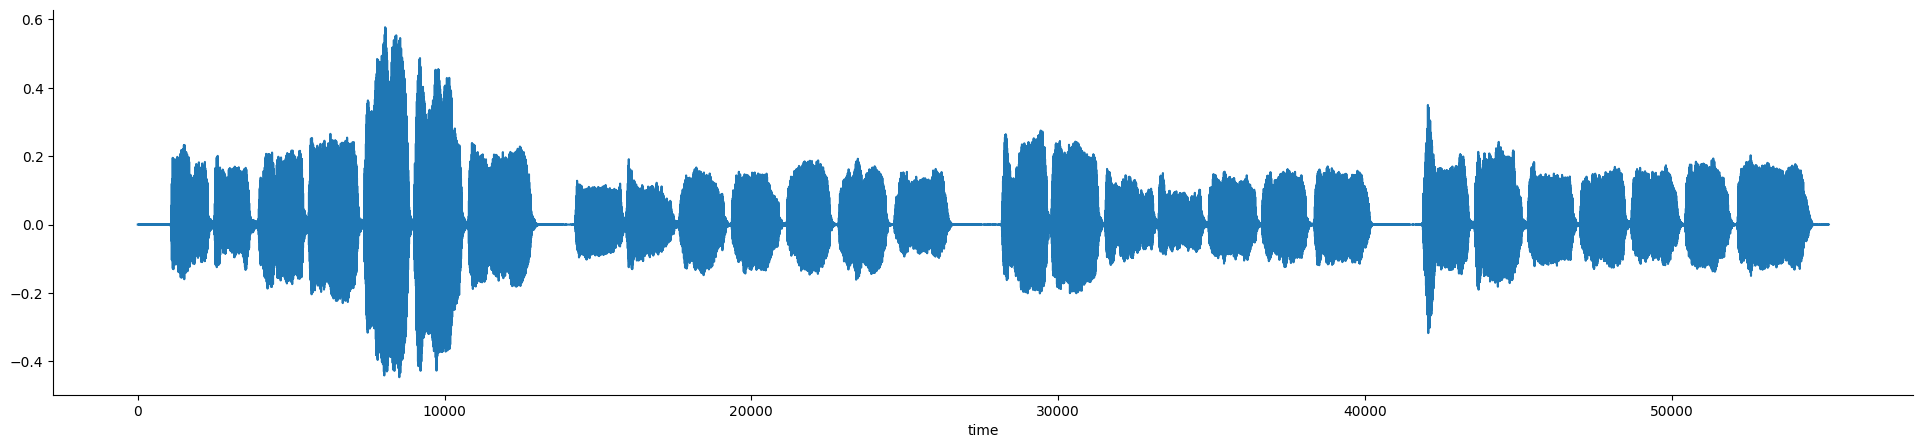

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(24,5)

audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
y, sr = librosa.load(audio_path, sr=22050//8)

ax.plot(y) #[:len(y)//8]
ax.spines[['right', 'top']].set_visible(False)
ax.set(xlabel='time', ylabel='')

In [18]:
20 * 22050//8

55125

[Text(0.5, 0, 'time'), Text(0, 0.5, '')]

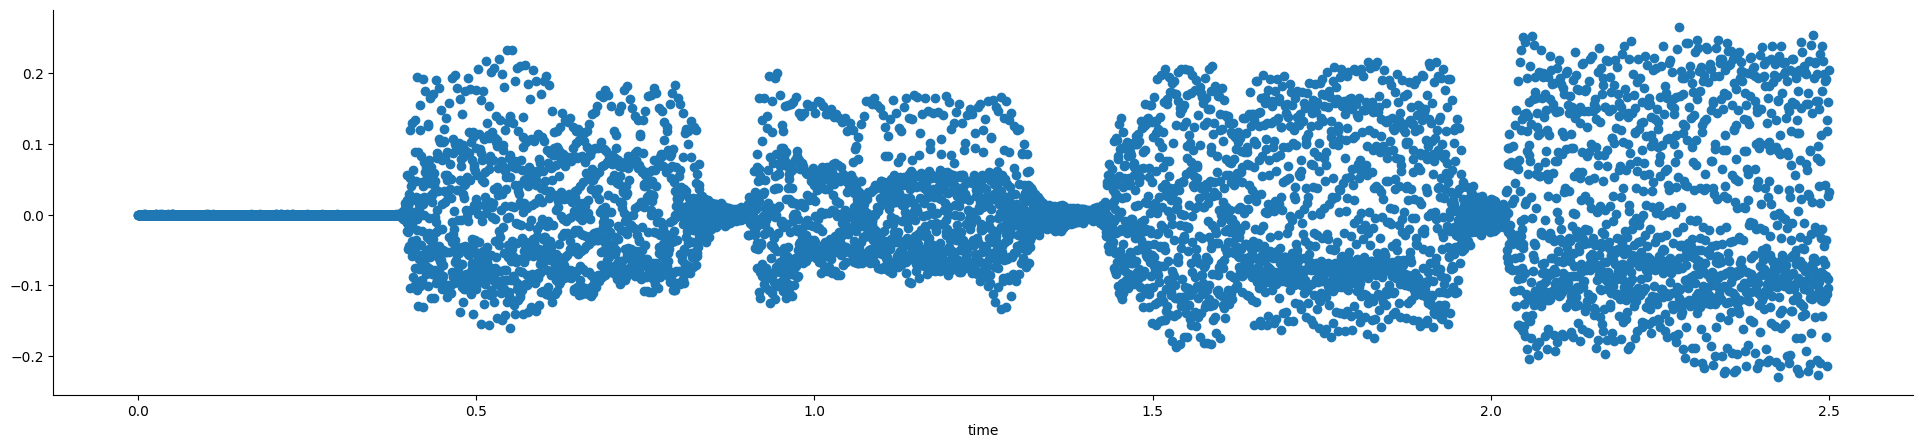

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(24,5)

audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
y, sr = librosa.load(audio_path, sr=22050//8)
x = np.linspace(0,20,len(y))
index = int(len(x)*0.125)
ax.scatter(x[:index], y[:index]) #[:len(y)//8]
ax.spines[['right', 'top']].set_visible(False)
ax.set(xlabel='time', ylabel='')

[Text(0.5, 0, 'time'), Text(0, 0.5, '')]

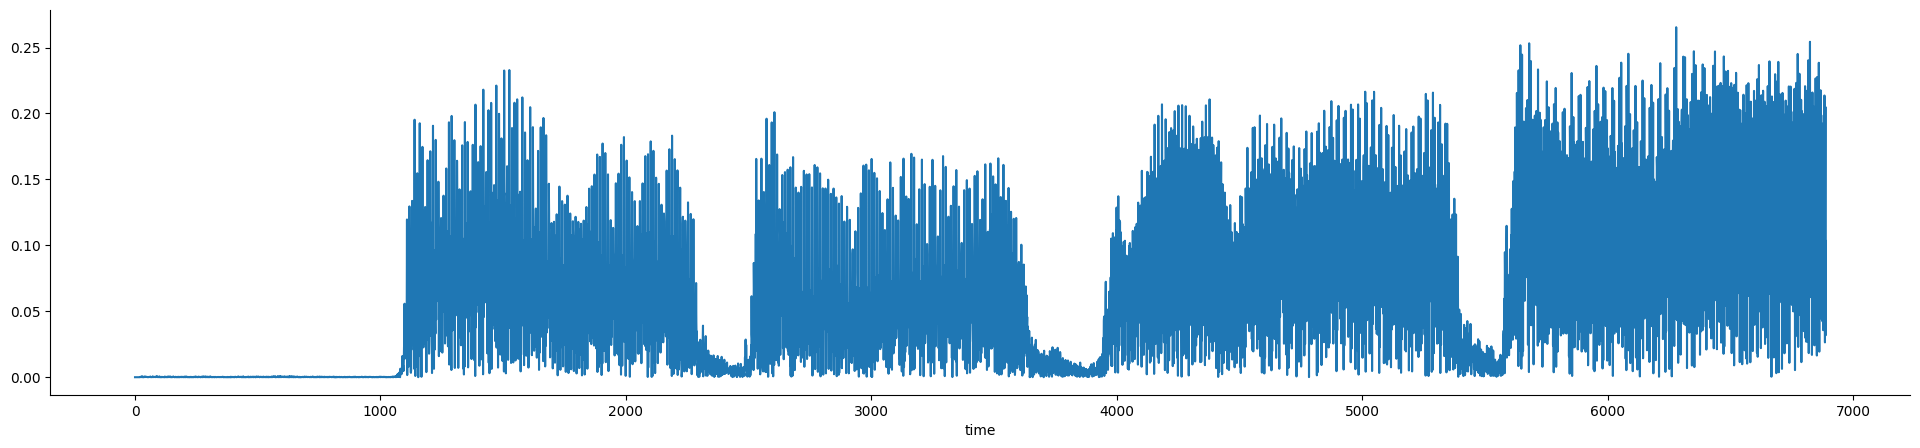

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(24,5)

audio_path = 'datos\Tarareos\wav_data_sync_with_midi\F01_0009_0001_2_D.wav'
y, sr = librosa.load(audio_path, sr=22050//8)

ax.plot(abs(y[:len(y)//8]))
ax.spines[['right', 'top']].set_visible(False)
ax.set(xlabel='time', ylabel='')

- L (duración de ventana) a muestras

In [29]:
# Convertir la duración de la ventana (L en segundos) a muestras por ventana
L = int(sr * lowest_time)

# Dividir la señal de audio en ventanas de longitud L
audio_frames = librosa.util.frame(y, frame_length=L, hop_length=L)

In [30]:
print('Ventanas audio real', librosa.get_duration(y=y, sr=sr) / lowest_time)
print('Ventanas audio real', librosa.get_duration(y=y, sr=sr) / lowest_time)

Ventanas audio real 160.0
Ventanas audio real 160.0


In [38]:
160 * lowest_time / 2

10.0

In [35]:
160 * lowest_time

20.0

In [40]:
audio_frames.shape[0] / 32

86.125

In [56]:
y_foo = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]).astype(float)
sr_foo = 4
low_time_foo = 0.5
L_foo = int(sr_foo * low_time_foo) #(sr * lowest_time)
librosa.util.frame(y_foo, frame_length=L_foo, hop_length=L_foo, axis=-1)
# N es la dimensión [0] del resultado

array([[ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.],
       [ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.]])

In [51]:
# Realizar STFT
stft_result = librosa.stft(y_foo, n_fft=L_foo, hop_length=L_foo)

# Obtener el espectrograma con N ventanas
spectrogram = np.abs(stft_result)